In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

MRT_8cluster_6_test = pd.read_csv('C:/Users/ching/Desktop/final project/data/MRT_Data_complete_0819/8cluster_6/8cluster_6_test.csv')


In [72]:
#MRT_8cluster_6_test['Sum_people'] = MRT_8cluster_6_test['Get_In_Count'] + MRT_8cluster_6_test['Way_Out_Count']
MRT_8cluster_6_test_0 = MRT_8cluster_6_test[['Sum_people','StnPres','Temperature','RH','WS','WD','Holiday']]

MRT_8cluster_6_test_0

,Sum_people,StnPres,Temperature,RH,WS,WD,Holiday
0,2511,1024.8,16.1,89.0,2.9,100,1
1,34,1024.7,15.9,90.0,2.5,100,1
2,0,1023.6,15.9,90.0,3.3,110,1
3,4935,1024.2,15.8,90.0,3.1,90,1
4,7053,1024.8,15.9,89.0,3.5,100,1
...,...,...,...,...,...,...,...
7660,32488,1026.6,14.0,88.0,3.0,110,0
7661,25018,1026.5,13.8,87.0,4.3,110,0
7662,25067,1026.3,14.2,82.0,4.1,110,0
7663,26629,1026.3,14.6,81.0,4.0,110,0


In [73]:
MRT_8cluster_6_test_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7665 entries, 0 to 7664
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sum_people   7665 non-null   int64  
 1   StnPres      7665 non-null   float64
 2   Temperature  7665 non-null   float64
 3   RH           7623 non-null   float64
 4   WS           7665 non-null   float64
 5   WD           7665 non-null   int64  
 6   Holiday      7665 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 419.3 KB


In [74]:
import datetime
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import models   
np.random.seed(16)

In [75]:
#全部轉成float
values = MRT_8cluster_6_test_0.values
values = values.astype('float32')
values

array([[2.5110e+03, 1.0248e+03, 1.6100e+01, ..., 2.9000e+00, 1.0000e+02,
        1.0000e+00],
       [3.4000e+01, 1.0247e+03, 1.5900e+01, ..., 2.5000e+00, 1.0000e+02,
        1.0000e+00],
       [0.0000e+00, 1.0236e+03, 1.5900e+01, ..., 3.3000e+00, 1.1000e+02,
        1.0000e+00],
       ...,
       [2.5067e+04, 1.0263e+03, 1.4200e+01, ..., 4.1000e+00, 1.1000e+02,
        0.0000e+00],
       [2.6629e+04, 1.0263e+03, 1.4600e+01, ..., 4.0000e+00, 1.1000e+02,
        0.0000e+00],
       [1.5728e+04, 1.0259e+03, 1.4600e+01, ..., 3.7000e+00, 1.0000e+02,
        0.0000e+00]], dtype=float32)

In [76]:
#正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[5.6366168e-02, 9.3318939e-01, 1.5234378e-01, ..., 3.6250001e-01,
        2.7777779e-01, 1.0000000e+00],
       [7.6322170e-04, 9.3103218e-01, 1.4453128e-01, ..., 3.1250000e-01,
        2.7777779e-01, 1.0000000e+00],
       [0.0000000e+00, 9.0732574e-01, 1.4453128e-01, ..., 4.1249999e-01,
        3.0555555e-01, 1.0000000e+00],
       ...,
       [5.6269640e-01, 9.6551704e-01, 7.8125030e-02, ..., 5.1249999e-01,
        3.0555555e-01, 0.0000000e+00],
       [5.9775972e-01, 9.6551704e-01, 9.3750030e-02, ..., 5.0000000e-01,
        3.0555555e-01, 0.0000000e+00],
       [3.5305738e-01, 9.5689583e-01, 9.3750030e-02, ..., 4.6250001e-01,
        2.7777779e-01, 0.0000000e+00]], dtype=float32)

In [77]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # 輸入(t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # 預測 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # concat起來
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 删除有空值的行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [78]:
# 前x小時，預測下一個小時
n_hours = 21
n_features = 7

reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()
#reframed.shape

,var1(t-21),var2(t-21),var3(t-21),var4(t-21),var5(t-21),var6(t-21),var7(t-21),var1(t-20),var2(t-20),var3(t-20),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
21,0.056366,0.933189,0.152344,0.845070,0.3625,0.277778,1.0,0.000763,0.931032,0.144531,...,0.6250,0.222222,1.0,0.038341,0.915947,0.136719,0.845070,0.4125,0.250000,0.0
22,0.000763,0.931032,0.144531,0.859155,0.3125,0.277778,1.0,0.000000,0.907326,0.144531,...,0.4125,0.250000,0.0,0.000494,0.915947,0.136719,0.845070,0.5000,0.250000,0.0
23,0.000000,0.907326,0.144531,0.859155,0.4125,0.305556,1.0,0.110779,0.920256,0.140625,...,0.5000,0.250000,0.0,0.000180,0.898706,0.144531,0.845070,0.4250,0.305556,0.0
24,0.110779,0.920256,0.140625,0.859155,0.3875,0.250000,1.0,0.158324,0.933189,0.144531,...,0.4250,0.305556,0.0,0.114865,0.907326,0.148438,0.830986,0.5125,0.250000,0.0
25,0.158324,0.933189,0.144531,0.845070,0.4375,0.277778,1.0,0.203174,0.950430,0.156250,...,0.5125,0.250000,0.0,0.319835,0.922413,0.156250,0.845070,0.4250,0.277778,0.0


In [79]:
# 分割為train及test
values = reframed.values
train_size = int(reframed.shape[0]*0.001) + 1
test_size = int(reframed.shape[0]*0.999)
train = values[:train_size, :]
test = values[train_size:, :]
print(train.shape)
print(test.shape)

(8, 154)
(7573, 154)


In [80]:
# var1~6是變數，var7是target
n_obs = n_hours * n_features 

train_X, train_y = train[:, :n_obs], train[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)

test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(test_X.shape, len(test_X), test_y.shape)

(8, 147) 8 (8,)
(7573, 147) 7573 (7573,)


In [81]:
# 轉成3维狀態 [資料數, 時間步長 ,變量數]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(8, 21, 7) (8,)
(7573, 21, 7) (7573,)


In [82]:
#載入模型
from keras import models   
model = models.load_model('c86_modle_weights_4.h5')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60)                16320     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 61        
Total params: 16,381
Trainable params: 16,381
Non-trainable params: 0
_________________________________________________________________


In [83]:
# 對test_X預測
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

yhat.shape
test_X.shape

(7573, 147)

In [84]:
# test_X的預測數值，恢復一般數值, inv_yhat
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat[0:300]

array([15333.944  , 15459.896  , 14234.449  , 12157.498  , 11797.641  ,
       13587.245  , 19784.81   , 28864.838  , 21998.842  , 14574.464  ,
       15761.576  , 13750.236  ,  4350.924  ,  1445.1185 ,  -840.3807 ,
        -391.824  ,  3250.1055 , 10610.213  , 21057.13   , 16950.86   ,
       15039.021  , 12900.99   , 13727.012  , 13560.183  , 11496.728  ,
       11811.57   , 14712.826  , 20440.8    , 28157.236  , 20488.84   ,
       14898.618  , 15155.106  , 14356.685  ,  4187.2046 ,  1104.1409 ,
        -212.3767 ,  -250.56276,  2631.6895 ,  9384.12   , 19437.664  ,
       16643.96   , 15125.387  , 13486.23   , 14469.386  , 14730.397  ,
       13965.395  , 13960.7    , 17744.932  , 24603.475  , 33181.395  ,
       24275.527  , 19576.055  , 18796.5    , 18137.008  ,  7465.1133 ,
        1642.1425 ,  -993.37854, -1162.5623 ,  3034.7751 ,  7956.562  ,
       12969.934  , 16049.346  , 16868.723  , 18252.158  , 20848.621  ,
       21913.46   , 20565.049  , 17559.26   , 20961.076  , 26239

In [85]:
# test_y, 恢復一般數值，inv_y
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y[0:300]

array([1.4738000e+04, 1.5465000e+04, 1.5333000e+04, 1.4724999e+04,
       1.4736000e+04, 1.6417000e+04, 2.4167002e+04, 3.0658000e+04,
       2.1224000e+04, 1.5114000e+04, 1.4482000e+04, 1.4090000e+04,
       4.7370000e+03, 1.4200000e+03, 1.7000000e+01, 2.0000000e+00,
       4.0010002e+03, 1.2616000e+04, 2.4308002e+04, 1.5862000e+04,
       1.2332000e+04, 1.2355000e+04, 1.3832999e+04, 1.3736000e+04,
       1.3352000e+04, 1.3873999e+04, 1.5671000e+04, 2.4248000e+04,
       3.0386000e+04, 2.0576000e+04, 1.4436000e+04, 1.4800000e+04,
       1.3966000e+04, 4.1800000e+03, 2.0840000e+03, 3.7000000e+01,
       2.0000000e+00, 4.1530000e+03, 1.3070000e+04, 2.4313002e+04,
       1.6182001e+04, 1.3358000e+04, 1.3284000e+04, 1.5073000e+04,
       1.6120000e+04, 1.5607000e+04, 1.6376000e+04, 1.9202000e+04,
       3.0676000e+04, 3.7074000e+04, 2.6860000e+04, 1.9412000e+04,
       1.9186000e+04, 1.9677000e+04, 6.5080000e+03, 2.2570000e+03,
       2.2000000e+01, 2.0000000e+00, 3.7340000e+03, 7.5130005e

In [86]:
# 計算 RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2377.167


C:\Users\ching\anaconda3\envs\ML_\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ching\anaconda3\envs\ML_\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 65293 missing from current font.
  font.set_text(s, 0, flags=flags)


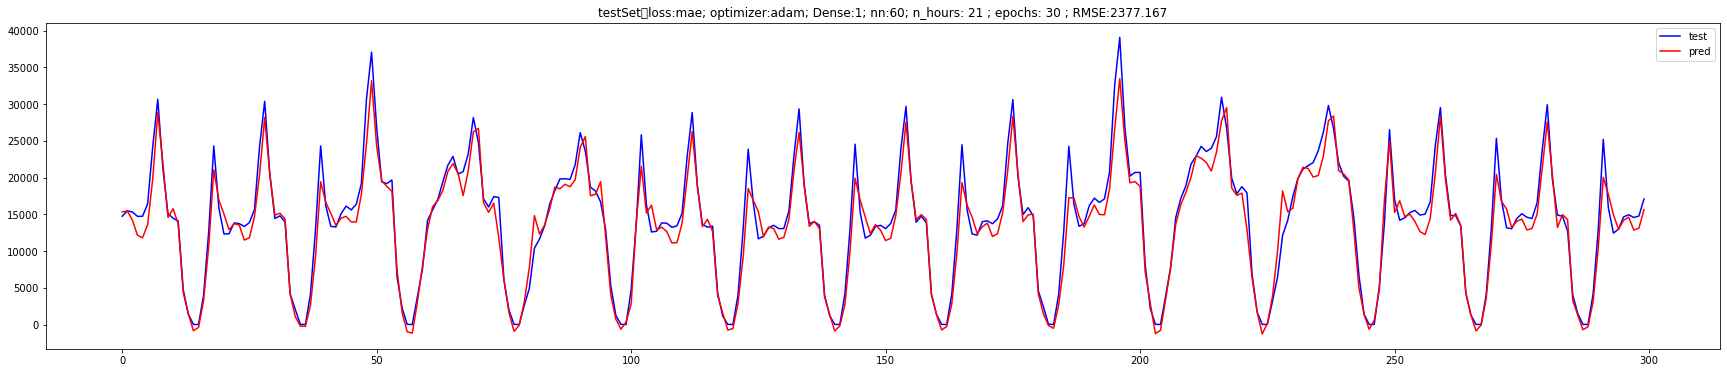

In [87]:
# inv_y與inv_yhat畫圖
# plot baseline and predictions
plt.figure(figsize=(30,6))
plt.plot(inv_y[0:300], label='test',color = 'blue') #實際人流
plt.plot(inv_yhat[0:300], label='pred', color = 'red') #預測人流
plt.title('testSet－loss:mae; optimizer:adam; Dense:1; nn:60; n_hours: 21 ; epochs: 30 ; RMSE:2377.167')
plt.legend()
plt.show()

In [88]:
sum(inv_yhat-inv_y)

-8085442.176172495